# bio.tools querying

## Overview

## Code

In [1]:
import sys
import json
import requests
import argparse
import yaml
import biotools_parse as bp
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt


# The call to get all bio.tools entries through the api is: https://bio.tools/api/tool/?format=json.
# Unfortunately, the response is limited to n tools. To get the whole set, the next pages must be retrieve.
# use "next" in the response to get succesive entries.
 
base_call = "https://bio.tools/api/tool/?format=json"


def make_request(URL):
    try:
        response = requests.get(URL)
    except:
        print('Could not make the request')
        return
    else:
        response = json.loads(response.text)
        return(response)

def build_url(next_page, filters):
    call_template = "https://bio.tools/api/tool/?{attributes}{next_page}&format=json"
    if next_page:
        next_page = "&%s"%next_page
    else:
        next_page = ""
    attributes = '&'.join(filters)    
    url = call_template.format(next_page=next_page, attributes=attributes)
    return(url)


def get_all_pages(filters):
    res = []
    next_page = "page=1"
    print('Starting making the requests...')
    while next_page:
        response = make_request(build_url(next_page, filters))
        print("Requesting: " + build_url(next_page, filters), end='\r')
        res = res + response["list"]
        next_page = response["next"]
        if next_page:
            next_page = next_page[1:]
    print('\nRequests finished.')
    return(res)

def save_result(out_path, result):
    with open(out_path, 'w') as out:
        json.dump(result, out)
    print('Result saved as ' + out_path )
    

colnames_general = ['name', 'description', 'type', 'topic', 'input', 'output']
colnames_detailed = [ 'name', 'description', 'version', 'type', 'topic', 'links', 'publication', 'download', 'inst_instr', 'test', 'src', 'os', 'input', 'output', 'dependencies', 'documentation', 'license', 'termsUse', 'contribPolicy', 'authors', 'repository']
def results_to_table(result, colnames):
    tools = bp.biotoolsToolsGenerator(result).instances
    # Load features into table
    colnames_features = colnames
    df_dict = {name : [] for name in colnames_features}

    for tool in tools:
        for field in colnames_features:
            df_dict[field].append(tool.__dict__.get(field))

    df_features = pd.DataFrame.from_dict(df_dict)
    df_features.drop_duplicates(subset ="name", keep = False, inplace = True) 
    return(df_features)


def parse_zooma_results(input_file):
    with open(input_file, 'r') as inp:
        zooma_terms_df = pd.read_csv(input_file)
        # getting list of terms
        terms = zooma_terms_df['iri']
        terms = []
        free_terms = []
        terms_label = {}
        for index, row in zooma_terms_df.iterrows():
            if type(row['iri']) == str:
                term = row['iri'].split('http://edamontology.org/')[1]
                terms.append(term)
                terms_label[term] = row['label']
            else:
                free_terms.append(row['keyword'])
                
    return(terms, terms_label, free_terms)

def build_filter(term):
    filters_template =  {'topic': 'topicID="%s"', 'format':'dataFormatID="%s"', 'operation':'operationID="%s"', 'data':'dataTypeID="%s"'}
    if 'topic' in term:
        filters = filters_template['topic']%(term)
    elif 'data' in term:
        filters = filters_template['data']%(term)
    elif 'operation' in term:
        filters = filters_template['operation']%(term)
    elif 'format' in term:
        filters = filters_template['format']%(term)
    return(filters)     

def query_for_terms(terms, EDAM=False):
    '''
    Takes a list of EDAM terms or free text keywords and does a query for each
    EDAM=True for edam terms, EDAM=False for freetext keywords. Default: EDAM=False.
    Return a dictionary of results of the form: {<term>: <dataframe of results>}
    '''
    free_filter_template = 'description="%s"'
    results = dict()
    results_detailed = dict()
    # Iteratre through terms
    for term in terms:
        term  = term.replace("/",'-')
        # Avoid duplicated queries
        if term not in results.keys():
            # Building the filters using the EDAM terms
            if EDAM == True:
                filter_ = [build_filter(term)]
            else:
                filter_ = [free_filter_template%(term)]
            # Do the query
            result = get_all_pages(filter_)
            # Put result in table
            result_df = results_to_table(result, colnames_general)
            result_detailed_df = results_to_table(result, colnames_detailed)
            # Put results table in dictionary with the results for the other terms
            results[term] = result_df
            results_detailed[term] = result_detailed_df
    return(results, results_detailed)

def count_tools_per_term(results):
    count_tools_per_term = {term :len(results[term]) for term in results.keys()}
    return(count_tools_per_term)

def tools_per_term(results):
    tools_per_term = {term:results[term]['name'] for term in results}  
    return(tools_per_term)

def merge_tools_lists(results):
    tools = set()
    for table in results:
        tools_per_term_ = tools_per_term(table)
        for term in tools_per_term_:
            for tool in tools_per_term_[term]:
                tools.add(tool)
    return(tools)

def save_results(results_general, terms_label, path):
    template_output = path + '/tools_%s.tsv'
    for term in results_general.keys():
        file_name = template_output%(terms_label[term])
        results_general[term].to_csv(file_name, index = False, sep='\t')

def save_lists_tools(tools_per_term,path, EDAM=False):
    if EDAM==True:
        template_output = path + '/tools_edam_%s.txt'
    else:
        template_output = path + '/tools_free_%s.txt'
    for term in tools_per_term.keys():
        with open(template_output%(term), 'w') as f:
            for item in tools_per_term[term]:
                f.write("%s\n" % item)
    

The attributes chosen to filter the query must be passed to the `get_all_pages` function in a list. Each attribute must be a string of the form `name=signalp`. This string will be put as a parameter in the query URL as it is. Please, follow the [bio.tools API reference](https://biotools.readthedocs.io/en/latest/api_reference.html) to construct this parameters successfully.

### Simple Query Example 1:

The following is an example of a query of tools annotted with the EDAM topic "Sequence composition, complexity and repeats" and with the word "game"  in their description. 

In [2]:
sample_filters = ['topic="Sequence composition, complexity and repeats"', 'description="game"']
filters = sample_filters
result = get_all_pages(filters)

Starting making the requests...
Requesting: https://bio.tools/api/tool/?topic="Sequence composition, complexity and repeats"&description="game"&page=1&format=json
Requests finished.


In [3]:
print(result)

[{'elixirCommunity': [], 'collectionID': ['EMBOSS'], 'accessibility': None, 'community': None, 'topic': [{'term': 'Sequence composition, complexity and repeats', 'uri': 'http://edamontology.org/topic_0157'}], 'owner': 'EMBOSS', 'cost': 'Free of charge', 'relation': [], 'download': [{'url': 'http://emboss.open-bio.org/html/adm/ch01s01.html', 'note': None, 'version': None, 'type': 'Source code'}, {'url': 'http://emboss.open-bio.org/html/adm/ch01s01.html', 'note': None, 'version': None, 'type': 'Binaries'}], 'validated': 1, 'publication': [{'doi': '10.1016/S0168-9525(00)02024-2', 'note': None, 'version': None, 'pmid': None, 'type': ['Primary'], 'pmcid': None, 'metadata': {'title': 'EMBOSS: The European Molecular Biology Open Software Suite', 'abstract': '', 'citationCount': 4828, 'authors': [{'name': 'Rice P.'}, {'name': 'Longden L.'}, {'name': 'Bleasby A.'}], 'date': '2000-06-01T00:00:00Z', 'journal': 'Trends in Genetics'}}, {'doi': '10.1017/CBO9781139151399', 'note': None, 'version': No

To save the rusult, use the `save_result(out_path, result)` funtion. `out_path` is the path where the `result` will be saved.

In [8]:
save_result('run_3.json', result)

Result saved as run_3.json


In [9]:
df_feaures = results_to_table(result)

###  Simple Query Example 2:

In [10]:
sample_filters = ['operation="Formatting"']
filters = sample_filters
result = get_all_pages(filters)

print("Number of tools found: %d"%len(result))

Starting making the requests...
Requesting: https://bio.tools/api/tool/?operation="Formatting"&page=39&format=json
Requests finished.
Number of tools found: 387


## Case 1: ETL tools discovery

We will query bio.tools using a set of EDAM terms that have being obtained after a mapping with ZOOMA.


### Step 1: parsing zooma results

ZOOMA results must be in a csv format.The colunm names, in this order, must be: `keyword`,`iri`,`label` and `confidence`. An example of a valid: 

|keyword            |iri                                   |label                      |confidence|
|-------------------|--------------------------------------|---------------------------|----------|
|Ontology annotation|http://edamontology.org/operation_0226|Annotation                 |MEDIUM    |
|Ontology annotation|                                      |                           |          |
|semantic annotation|                                      |                           |          |
|semantic annotation|http://edamontology.org/operation_3778|Text annotation            |MEDIUM    |
|Text mining        |http://edamontology.org/topic_0218    |Natural language processing|GOOD      |

Raw: 

```
keyword,iri,label,confidence
Ontology annotation,http://edamontology.org/operation_0226,Annotation,MEDIUM
Ontology annotation,,,
semantic annotation,,,
semantic annotation,http://edamontology.org/operation_3778,Text annotation,MEDIUM
Text mining,http://edamontology.org/topic_0218,Natural language processing,GOOD
```

The function `parse_zooma_results` parses this csv and returns a list of terms suitable for the querying.

For a mapping of keyword related with ETL against EDAM, we got the ZOOMA results in the path `ETL_EDAM_curated.csv`.

In [10]:
terms_file='ETL_EDAM_curated.csv'
ETL_edam_terms, terms_label_ETL, free_terms = parse_zooma_results(terms_file)
print(ETL_edam_terms)
print(terms_label_ETL)
print(free_terms)

['data_2337', 'data_0949', 'operation_3907', 'topic_3489', 'data_2337', 'topic_3572', 'operation_0336', 'operation_0335', 'operation_3434', 'operation_1812', 'data_0842', 'data_0006', 'topic_3366']
{'data_2337': 'Resource metadata', 'data_0949': 'Workflow metadata', 'operation_3907': 'Information extraction', 'topic_3489': 'Database management', 'topic_3572': 'Data quality management', 'operation_0336': 'Format validation', 'operation_0335': 'Formatting', 'operation_3434': 'Conversion', 'operation_1812': 'Parsing', 'data_0842': 'Identifier', 'data_0006': 'Data', 'topic_3366': 'Data integration and warehousing'}
['Provenance', 'Documentation', 'Data structure', 'Data structure', 'Workflow management', 'Extraction:', 'Data querying', 'Data import', 'File reader', 'File reader', 'read/load metadata', 'Data validation', 'Data harmonisation', 'Field mapping', 'Data packaging', 'Data packaging', 'Data validation', 'Data validation']


### Step 2: doing the queries. 

#### Step 2.1: EDAM queries

The function `query_for_terms` does the quering for the previously obtained list of EDAM terms when second argument set to `True`. It resturns two kind of outputs: general and detailed. Each is a dictionary of the form: `{<term>: <dataframe of results>}`

In [54]:
ETL_edam_results_general, ETL_edam_results_detailed  = query_for_terms(ETL_edam_terms, True)

Starting making the requests...
Requesting: https://bio.tools/api/tool/?dataTypeID="data_2337"&page=2&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?dataTypeID="data_0949"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?operationID="operation_3907"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_3489"&page=19&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_3572"&page=18&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?operationID="operation_0336"&page=2&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?operationID="operation_0335"&page=36&format=json
Requests finished.
Starting making the requests...
Requesting: https://

We save the result of each term in a separated file inside the `outputs/ETL` directory using the function `save_results`.

In [14]:
path_output_ETL = "outputs/ETL"
Path(path_output_ETL).mkdir(parents=True, exist_ok=True)
save_results(ETL_edam_results_general, terms_label_ETL, path_output_ETL)

#### Step 2.2: free text queries

In [85]:
ETL_free_results_general, ETL_free_results_detailed  = query_for_terms(free_terms, False)

Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Provenance"&page=2&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Documentation"&page=16&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Data structure"&page=4&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Workflow management"&page=2&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Extraction:"&page=36&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Data querying"&page=1&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?description="Data import"&page=1&format=json
Requests finished.
Starting making the requests...


In [ ]:
print()

### Analyzing results

#### Total number of terms

In [55]:
len(ETL_edam_results_general.keys())

12

In [86]:
len(ETL_free_results_general.keys())

13

#### Tools per term

In [87]:
count_tools_per_term(ETL_edam_results_general)

{'data_2337': 10,
 'data_0949': 2,
 'operation_3907': 6,
 'topic_3489': 177,
 'topic_3572': 171,
 'operation_0336': 15,
 'operation_0335': 339,
 'operation_3434': 21,
 'operation_1812': 193,
 'data_0842': 66,
 'data_0006': 328,
 'topic_3366': 63}

In [88]:
count_tools_per_term(ETL_free_results_general)

{'Provenance': 14,
 'Documentation': 152,
 'Data structure': 34,
 'Workflow management': 15,
 'Extraction:': 342,
 'Data querying': 1,
 'Data import': 8,
 'File reader': 0,
 'read-load metadata': 0,
 'Data validation': 0,
 'Data harmonisation': 0,
 'Field mapping': 0,
 'Data packaging': 9}

#### Lists of tool names per term
This is handy for validation

In [59]:
tools_per_term_ETL = tools_per_term(ETL_edam_results_general)
tools_per_term_ETL = {terms_label_ETL[term]:tools_per_term_ETL[term] for term in tools_per_term_ETL.keys()}

In [89]:
tools_per_term_free_ETL = tools_per_term(ETL_free_results_general)
tools_per_term_free_ETL = {term:tools_per_term_free_ETL[term] for term in tools_per_term_free_ETL.keys()}

We save the list of tools for each term in separated txt files.

In [77]:
save_lists_tools(tools_per_term_ETL, path_output_ETL, True)

In [90]:
save_lists_tools(tools_per_term_free_ETL, path_output_ETL, False)

#### Merged tools lists
All tools discovered merged in a single set

In [91]:
all_ETL_tools = merge_tools_lists([ETL_edam_results_general, ETL_free_results_general])
all_ETL_tools

{'blastgui',
 'seqminer',
 'hgv_beam',
 'meffil',
 'pads arsenal',
 'dictybase update 2011',
 'pertinint',
 'snphood',
 'imagedataextractor',
 'lst',
 'hiv-drlink',
 'metaspades',
 'vmd store',
 'bamhash',
 'pubmed',
 'hgv_ldtools',
 'featureextract',
 'hmmcopy',
 'sabund',
 'baget',
 'gostats',
 'pacsy',
 'frogs_affiliation_otu',
 'pina',
 'geoss',
 'leb',
 'metandem',
 'molmeth',
 'radar-base',
 'compareoverlappingsmallref',
 'prosight ptm',
 'mala',
 'computecoverage',
 'snpediar',
 'stategra',
 'applemdo',
 'interactiontransformer',
 'dbcrid',
 'vcfr',
 'psea',
 'international protein index (ipi)',
 'tfm',
 'gatk_haplotype_caller',
 'bagging-svm',
 'fmm',
 'm-gcta',
 'fusion',
 'falcon server',
 'qmsat',
 'msimageview',
 'american type culture collection (atcc)',
 'xia2',
 'wft4galaxy',
 'antholigo',
 'fastqz',
 'phred',
 'retrorules',
 'annotategenes',
 'gnomad',
 'h-dbas',
 'altis',
 'pcaexplorer',
 'damidseq_pipeline',
 'cornai',
 'fish - profile search',
 'pergola-web',
 'gdtoo

In [92]:
len(all_ETL_tools)

1742

### ETL related annotations count. EDAM queries

In [65]:
matches_tools = {}
for tool in list(all_ETL_tools):
    matches = 0
    for l in tools_per_term_ETL.values():
        if tool in list(l):
            matches += 1
    matches_tools[tool] = matches

ETL_annot_count_df = pd.DataFrame(list(matches_tools.items()), columns= ['tool','ETL annotations count']).sort_values('ETL annotations count', ascending=False)
print(ETL_annot_count_df)

                                               tool  ETL annotations count
1657                                       martview                      3
186                                ms-data-core-api                      3
338                                        jmztab-m                      3
1473                                         libmgf                      3
931                           extract_archive_merge                      3
...                                             ...                    ...
308                                           episo                      0
1354                                   lineagepulse                      0
305   investigation of (non canonical) splice sites                      0
957                                  samplesheet.py                      0
758                                           alitv                      0

[1768 rows x 2 columns]


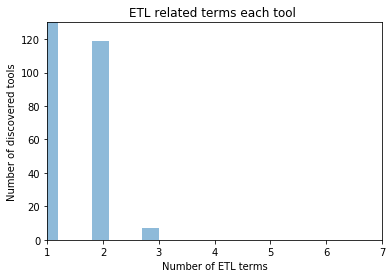

In [69]:
plt.hist(ETL_annot_count_df['ETL annotations count'],alpha=0.5)
plt.xlim([1, 7])
plt.ylim([0, 130])
plt.title('ETL related terms each tool ')
plt.xlabel('Number of ETL terms')
plt.ylabel('Number of discovered tools')
plt.show()

### ETL related annotations count. Free text queries

In [93]:
matches_tools = {}
for tool in list(all_ETL_tools):
    matches = 0
    for l in tools_per_term_free_ETL.values():
        if tool in list(l):
            matches += 1
    matches_tools[tool] = matches

ETL_annot_count_df = pd.DataFrame(list(matches_tools.items()), columns= ['tool','ETL annotations count']).sort_values('ETL annotations count', ascending=False)
print(ETL_annot_count_df)

                     tool  ETL annotations count
823                 sider                      2
528                  vect                      2
940   bioseq-analysis 2.0                      2
1611              civicpy                      2
637               ppr-ssm                      2
...                   ...                    ...
697               asm2ace                      0
696                phemto                      0
695             seqassist                      0
693                  ddbj                      0
1741             genatlas                      0

[1742 rows x 2 columns]


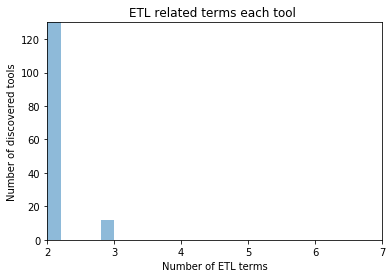

In [100]:
plt.hist(ETL_annot_count_df['ETL annotations count'],alpha=0.5)
plt.xlim([2, 7])
plt.ylim([0, 130])
plt.title('ETL related terms each tool ')
plt.xlabel('Number of ETL terms')
plt.ylabel('Number of discovered tools')
plt.show()

### ETL related annotations count. Free text and EDAM queries 

In [95]:
matches_tools = {}
for tool in list(all_ETL_tools):
    matches = 0
    for l in tools_per_term_free_ETL.values():
        if tool in list(l):
            matches += 1
    for l in tools_per_term_ETL.values():
        if tool in list(l):
            matches += 1
    matches_tools[tool] = matches

ETL_annot_count_df = pd.DataFrame(list(matches_tools.items()), columns= ['tool','ETL annotations count']).sort_values('ETL annotations count', ascending=False)
print(ETL_annot_count_df)

                tool  ETL annotations count
960            croco                      3
1584       idconvert                      3
1611         civicpy                      3
1455          libmgf                      3
334         jmztab-m                      3
...              ...                    ...
617       exonfinder                      1
616       bioalcidae                      1
615   xtandem parser                      1
612          extract                      1
1741        genatlas                      1

[1742 rows x 2 columns]


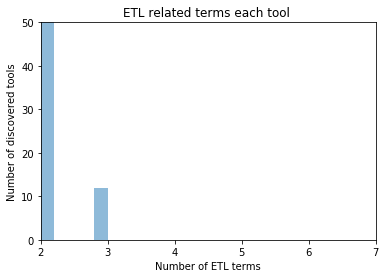

In [101]:
plt.hist(ETL_annot_count_df['ETL annotations count'],alpha=0.5)
plt.xlim([2, 7])
plt.ylim([0, 50])
plt.title('ETL related terms each tool ')
plt.xlabel('Number of ETL terms')
plt.ylabel('Number of discovered tools')
plt.show()

## Case 2: Ontology tools discovery

In this case, the file of zooma results is `ontology_annotation_EDAM_curated_csv.csv`.

### Step 1: parsing zooma results

In [24]:
terms_file='ontology_annotation_EDAM_curated_csv.csv'
ontology_edam_terms, terms_label_ontology = parse_zooma_results(terms_file)
print(ontology_edam_terms)
print(terms_label_ontology)

['operation_0226', 'operation_3778', 'topic_0089', 'operation_3280']
{'operation_0226': 'Annotation', 'operation_3778': 'Text annotation', 'topic_0089': 'ontology and terminology', 'operation_3280': 'Named-entity and concept recognition'}


### Step 2: doing the query. 

In [25]:
ontology_results_general, ontology_results_detailed  = query_for_EDAM_terms(ontology_edam_terms)

Starting making the requests...
Requesting: https://bio.tools/api/tool/?operationID="operation_0226"&page=14&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?operationID="operation_3778"&page=5&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?topicID="topic_0089"&page=29&format=json
Requests finished.
Starting making the requests...
Requesting: https://bio.tools/api/tool/?operationID="operation_3280"&page=6&format=json
Requests finished.


In [49]:
path_output_ontology = "outputs/ontology"
Path(path_output_ontology).mkdir(parents=True, exist_ok=True)
save_results(ontology_results_general, terms_label_ontology, path_output_ontology)

#### Total number of terms

In [50]:
len(ontology_results_general.keys())

4

#### Tools per term

In [51]:
count_tools_per_term(ontology_results_general)

{'operation_0226': 145,
 'operation_3280': 61,
 'operation_3778': 47,
 'topic_0089': 304}

#### Lists of tool names per term
This is handy for validation

In [53]:
tools_per_term_ontology = tools_per_term(ontology_results_general)

In [54]:
save_lists_tools(tools_per_term_ontology, path_output_ontology)

#### Merged tools lists
All tools discovered merged in a single set

In [55]:
all_ontology_tools = merge_tools_lists(ontology_results_general)
all_ontology_tools

{'a4preproc',
 'aber-owl',
 'acela',
 'aceparser',
 'ads',
 'agrigo',
 'ahtpdb',
 'aiso',
 'ajia',
 'alliance genome resources',
 'amigo 2',
 'amtdb',
 'anabel',
 'aniseed',
 'annot',
 'annotationfilter',
 'annotsv',
 'apache taverna',
 'arachnoserver',
 'aristo',
 'asa-ps',
 'aspgd',
 'association viewer',
 'bagel2',
 'becas',
 'beere',
 'bel commons',
 'bel2abm',
 'belief',
 'bgeedb',
 'bio.tools',
 'bio2bel',
 'biobert',
 'biocaddie',
 'biocatalogue',
 'bioecs',
 'bioexcel genome sequence quality control workflow',
 'biogateway',
 'biojs-vis-gprofiler',
 'biolabeler',
 'biolit',
 'biomoby',
 'biomodels database',
 'bionda - biomarker database',
 'bioner',
 'bionet-mining',
 'bioportal',
 'bior',
 'bittersweet',
 'biwalklda',
 'bo-lstm',
 'brisskit',
 'bubastis',
 'bugbuilder',
 'cagefightr',
 'calchas',
 'candida genome database cgd',
 'card',
 'cargo',
 'carmo',
 'causalbuilder',
 'caw',
 'cbo',
 'cddapp',
 'cdfread',
 'cedar ondemand',
 'cellbaser',
 'ceu mass mediator',
 'charpro

In [82]:
len(all_ontology_tools)

476

### Ontology related annotations count

In [101]:
matches_tools = {}
for tool in list(all_ontology_tools):
    matches = 0
    for l in tools_per_term_ontology.values():
        if tool in list(l):
            matches += 1
    matches_tools[tool] = matches

ontology_annot_count_df = pd.DataFrame(list(matches_tools.items()), columns= ['tool','ontology annotations count']).sort_values('ontology annotations count', ascending=False)
print(ontology_annot_count_df)

                  tool  ontology annotations count
258              acela                           3
229            ppr-ssm                           3
211              craft                           3
237             belief                           2
112  yeast metaboliner                           2
..                 ...                         ...
166           brisskit                           1
164      arachnoserver                           1
163        ontobrowser                           1
161              ggost                           1
474         facta plus                           1

[475 rows x 2 columns]


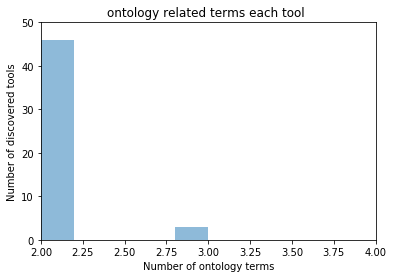

In [103]:
plt.hist(ontology_annot_count_df['ontology annotations count'],alpha=0.5)
plt.xlim([2, 4])
plt.ylim([0, 50])
plt.title('ontology related terms each tool ')
plt.xlabel('Number of ontology terms')
plt.ylabel('Number of discovered tools')
plt.show()